# TODO

 - equatorial trapped wave theoratical dispersion relation
 - separate Background PSD

# Documentation
 - FFT convention for plane-wave solutions (especially temporal-frequency)
 - Input data dimesion requirement


# Body

## Import

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import netCDF4 as nc
import numpy as np
import scipy.signal as signal

## Global Variable and Function

In [2]:
path_Satellite = "/work/b08209033/DATA/IndianMonsoon/Satellite"

## Unittest

In [3]:
def get_kelvin_wave():
    # Define parameters
    # (x, y) resolution
    R = 6371 * 1e3
    Lx = 2 * np.pi * R
    Ly = np.pi * R
    Nx = 256
    Ny = 128
    # (t) resolution
    Lt = 1801
    Nt = Lt
    # wavenumber and frequency
    WAVENUMBER = 3
    wavelength = Lx / WAVENUMBER
    PERIOD = 60

    # Define grids
    x = np.linspace(0, Lx, Nx, endpoint=False)
    y = np.linspace(-Ly / 2, Ly / 2, Ny + 2)[1:-1]
    t = np.linspace(0, Lt, Nt, dtype=int, endpoint=False)
    T, Y, X = np.meshgrid(t, y, x, indexing="ij")

    # Define kelvin wave
    def _get_kelvin_wave(X, Y, T):
        Y_structure = np.exp(-(Y**2) / (500e3) ** 2)
        X_structure = np.exp(1j * (2 * np.pi / wavelength) * X)
        T_structure = np.exp(1j * -(2 * np.pi / PERIOD) * T)
        return Y_structure * X_structure * T_structure

    kelvin_wave = _get_kelvin_wave(X, Y, T)

    return kelvin_wave, (t, np.rad2deg(y / R), np.rad2deg(x / R))


def unittest_kelvin_wave():
    """ """
    kelvin_wave, kelvin_wave_grids = get_kelvin_wave()

    time, lat, lon = kelvin_wave_grids

    # Hovmoller Diagram
    display_time = 90
    plt.figure()
    plt.contourf(
        lon,
        time[:display_time],
        np.real(kelvin_wave[:display_time, len(lat) // 2, :]),
        levels=32,
        cmap="RdBu",
    )

    # Power spectrum
    # Generally, exp(i(k*x-omega*t)) represent POSITIVE k and POSITIVE omega (eastward-moving)
    wavenumbers = np.fft.fftshift(np.fft.fftfreq(len(lon), 1 / len(lon)))
    frequencys = np.fft.fftshift(np.fft.fftfreq(len(time), 1))
    with np.errstate(divide="ignore", invalid="ignore"):
        periods = np.where(frequencys != 0, 1 / frequencys, 0)
    signals = kelvin_wave[:, len(lat) // 2, :]
    # longitude (e^ikx)
    kelvin_wave_fft = np.fft.fft(signals, axis=-1, norm="ortho")
    # time (e^i(-w)t)
    kelvin_wave_fft = np.fft.ifft(kelvin_wave_fft, axis=0, norm="ortho")
    kelvin_wave_fft = np.fft.fftshift(kelvin_wave_fft)
    power_spec = np.abs(kelvin_wave_fft) ** 2

    # parseval identity
    print("In time-spatial domain", np.sum(np.abs(signals) ** 2))
    print("In frequency-wavenumber domain", np.sum(power_spec))

    # power spec
    plt.figure()
    plt.contourf(wavenumbers, periods, np.log10(power_spec), levels=16)
    plt.xlim(-5, 5)
    plt.ylim(-80, 80)
    return None

In [4]:
# unittest_kelvin_wave()

## Main

In [5]:
segment_length = 96
segment_day = 96
overlap_length = 65

In [6]:
def load_OLR_data(file_path, file_name):
    """
    Load Outgoing Longwave Radiation (OLR) data from a NetCDF file.

    Parameters:
    file_path (str): Path to the directory containing the file.
    file_name (str): Name of the NetCDF file to load.

    Returns:
    tuple: A tuple containing:
        - olr_data (ndarray): OLR data from the file.
        - (time, latitudes, longitudes): A tuple containing the time, latitude, and longitude arrays.
    """
    full_path = os.path.join(file_path, file_name)

    if not os.path.exists(full_path):
        raise FileNotFoundError(
            f"The file {file_name} does not exist in the directory {file_path}."
        )

    dataset = nc.Dataset(full_path)
    longitudes = dataset["lon"][:]
    latitudes = dataset["lat"][:]
    time = dataset["time"][:]
    olr_data = dataset["olr"][:]

    return olr_data, (time, latitudes, longitudes)


def decompose_symmetric_antisymmetric(data, axis):
    """
    Decompose data into its symmetric and antisymmetric components along a specified axis.

    Parameters:
    data (ndarray): Input data to decompose.
    axis (int): Axis along which to perform the decomposition.

    Returns:
    tuple: A tuple containing:
        - symmetric_component (ndarray): Symmetric part of the data.
        - antisymmetric_component (ndarray): Antisymmetric part of the data.
    """
    symmetric_component = (data + np.flip(data, axis=axis)) / 2
    antisymmetric_component = (data - np.flip(data, axis=axis)) / 2
    return symmetric_component, antisymmetric_component


def compute_segmented_PSD(
    data, data_grid, segment_length=96, overlap_length=65, taper=None
):
    """
    Calculate the stochastic Power Spectral Density (PSD) from time series data segmented with overlap.

    Parameters:
    data : ndarray
        Input data array with dimensions (time, latitude, longitude).
    data_grid : tuple
        Tuple containing (time, latitude, longitude) arrays.
    segment_length : int, optional
        Length of each time segment for FFT analysis. Default is 96.
    overlap_length : int, optional
        Number of overlapping points between segments. Default is 65.
    taper : ndarray, optional
        Custom tapering window to apply to each segment. If None, a default Hanning-like taper is applied.

    Returns:
    PSD : ndarray
        The computed power spectral density.
    (wavemode_time, wavemode_longitude) : tuple of ndarrays
        Wavemodes (nondimensional ordinary wavenumber) in time and longitude.

    Notes:
    - All operations are performed on data points, meaning the units of the data are not considered in the calculations.
      Users should ensure that units and the actual spatial and temporal spacing are handled appropriately outside this function.
    - The resulting `wavemode_time` and `wavemode_longitude` represent the number of wave cycles or modes that fit in the total time
      and over the spatial dimension (longitude), respectively, not actual physical frequencies or wavenumbers.
    """

    def segment_data(array, segment_length, overlap_length):
        """Segments input array into overlapping subarrays."""
        step = segment_length - overlap_length
        num_segments = (len(array) - overlap_length) // step
        segmented_array = np.array(
            [array[i : i + segment_length] for i in range(0, num_segments * step, step)]
        )
        return segmented_array

    def default_taper():
        """Generate default Hanning-like taper over first and last third of the segment."""
        taper_window = np.ones(segment_length)
        third_len = 30
        taper_cosine = 0.5 * (
            1 - np.cos(2 * np.pi * np.arange(third_len) / (2 * third_len))
        )
        taper_window[:third_len] = taper_cosine
        taper_window[-third_len:] = taper_cosine[::-1]
        return taper_window

    time, latitudes, longitudes = data_grid
    if data.shape != (len(time), len(latitudes), len(longitudes)):
        raise ValueError("Input data dimensions must match grid dimensions.")

    if taper is None:
        taper_window = default_taper().reshape(1, -1, 1, 1)
    else:
        taper_window = taper

    # segmentation
    tmp = segment_data(np.copy(data), segment_length, overlap_length)
    # detrend
    tmp = signal.detrend(tmp, axis=1)
    # tapering
    tmp = np.multiply(tmp, taper_window)
    # fft over longitude
    tmp = np.fft.fft(tmp, axis=3, norm="ortho")
    # fft over time
    tmp = np.fft.ifft(tmp, axis=1, norm="ortho")
    # power spectrum
    tmp = np.abs(tmp) ** 2
    # mean over segment number
    tmp = np.mean(tmp, axis=0, keepdims=True)
    # sum over latitude
    tmp = np.sum(tmp, axis=2, keepdims=True)
    # zero-center PSD diagram
    PSD = np.fft.fftshift(tmp.squeeze())

    # Compute nondimensional ordinary wavenumber for longitude and time
    wavemode_longitude = np.fft.fftshift(
        np.fft.fftfreq(len(longitudes), 1 / len(longitudes))
    )
    wavemode_time = np.fft.fftshift(np.fft.fftfreq(segment_length, 1 / segment_length))

    return PSD, (wavemode_time, wavemode_longitude)


def extract_positive_PSD(PSD, spectral_grid, axis=0):
    """
    Extract the positive half of a symmetric Power Spectral Density (PSD) along the specified axis,
    while preserving Parseval's identity. Assumes the input signal is real-valued, leading to Hermitian
    symmetry in the spectral domain.

    Parameters:
    PSD : ndarray
        The 2D Power Spectral Density array.
    spectral_grid : tuple of ndarrays
        Tuple containing the frequency/wavenumber grids for the corresponding axes.
    axis : int, optional
        The axis along which to extract the positive half of the PSD. Default is 0 (time axis).

    Returns:
    positive_psd : ndarray
        The positive half of the PSD with the specified axis halved.
    (positive_frequencies, wavenumbers) : tuple of ndarrays
        The corresponding positive frequencies (or wavenumbers) and the unmodified spectral grid.
    """
    frequencies = spectral_grid[axis]
    midpoint = len(frequencies) // 2

    # Roll the specified axis to the front for easier manipulation
    PSD = np.moveaxis(PSD, axis, 0)

    if len(frequencies) % 2 == 0:
        # Even case: Include the highest frequency without doubling
        positive_psd = np.concatenate([PSD[midpoint:], PSD[[0]]], axis=0)
        positive_psd[1:-1] *= 2  # Double the power for positive frequencies
        positive_frequencies = np.flip(np.abs(frequencies[: midpoint + 1]))
    else:
        # Odd case: Handle the midpoint and avoid double counting
        positive_psd = np.copy(PSD[midpoint:])
        positive_psd[1:] *= 2  # Double the power for positive frequencies
        positive_frequencies = frequencies[midpoint:]

    # Move the axis back to its original position
    positive_psd = np.moveaxis(positive_psd, 0, axis)

    # Modify the spectral grid for the specified axis, leaving others untouched
    modified_spectral_grid = list(spectral_grid)
    modified_spectral_grid[axis] = positive_frequencies

    return positive_psd, tuple(modified_spectral_grid)


def apply_121_filter(array, axis, iterations):
    """
    Apply a 1-2-1 Gaussian filter along the specified axis, ensuring energy conservation at boundaries.
    """

    def extend_boundaries(arr, ax):
        """Extend boundaries by duplicating the first and last elements along the specified axis."""
        if ax < 0 or ax >= arr.ndim:
            raise ValueError(
                f"Axis {ax} is out of bounds for array of dimension {arr.ndim}."
            )

        # Create slices for the first and last elements along the axis
        first_slice = [slice(None)] * arr.ndim
        last_slice = [slice(None)] * arr.ndim
        first_slice[ax] = slice(0, 1)
        last_slice[ax] = slice(-1, None)

        # Concatenate the boundaries
        extended_arr = np.concatenate(
            [arr[tuple(first_slice)], arr, arr[tuple(last_slice)]], axis=ax
        )
        return extended_arr

    def convolve_along_axis(data, axis, kernel):
        """Extend boundaries and convolve along the specified axis."""
        extended_data = extend_boundaries(data, axis)
        return np.apply_along_axis(
            lambda m: np.convolve(m, kernel, mode="valid"), axis=axis, arr=extended_data
        )

    kernel = np.array([1 / 4, 1 / 2, 1 / 4])

    result = np.copy(array)
    for _ in range(iterations):
        result = convolve_along_axis(result, axis, kernel)

    return result

In [7]:
# wavenumbers = np.fft.fftshift(np.fft.fftfreq(len(lon), 2*np.pi*EARTH_RADIUS_METERS / len(lon)))*2*np.pi # angular wavenumber
# wavemodes = wavenumbers/(2*np.pi)*(2*np.pi*6371E3)

# frequencies = np.fft.fftshift(np.fft.fftfreq(segment_length, 86400))
# print(frequencies * segment_length * 86400)

In [14]:
# Load and crop OLR data around the equator
olr_data, grid_coords = load_OLR_data(path_Satellite, "OLR_detrended.nc")
lat_range = [np.argmax(grid_coords[1] >= -15), np.argmax(grid_coords[1] >= 15)]
olr_data = olr_data[:, lat_range[0] : lat_range[1], :]
grid_coords = (
    grid_coords[0],
    grid_coords[1][lat_range[0] : lat_range[1]],
    grid_coords[2],
)

# Symmetric and antisymmetric decomposition
olr_symmetric, olr_antisymmetric = decompose_symmetric_antisymmetric(olr_data, axis=1)

# Compute PSD for symmetric, antisymmetric, and total
psd_symmetric, spectral_grid = compute_segmented_PSD(olr_symmetric, grid_coords)
psd_antisymmetric, spectral_grid = compute_segmented_PSD(olr_antisymmetric, grid_coords)
psd_total = psd_symmetric + psd_antisymmetric

# Apply filtering to obtain background PSD
background_psd = apply_121_filter(
    apply_121_filter(psd_total / 2, axis=1, iterations=10), axis=0, iterations=10
)

# Dimensionalize frequency
# From nondimensional ordinary wavenumber to ordinary wavenumber
# (cycles) -->  (cycles/day))
spectral_grid = (spectral_grid[0] / segment_day, spectral_grid[1])

In [19]:
def plot_spectral_contour(
    PSD_data,
    spectral_grid,
    wavenumber_range,
    levels_contourf,
    levels_contour,
    title,
    xlabel,
    ylabel,
    log_value=True,
):
    """Helper function to plot a spectral contour with filled levels and contours."""
    wavenumbers, positive_frequencies = spectral_grid[1], spectral_grid[0]
    plt.rcParams.update({"font.size": 22})

    plt.figure(figsize=(16, 9), dpi=160)

    wavenum_indices = slice(
        np.argmax(wavenumbers >= wavenumber_range[0]),
        np.argmax(wavenumbers >= wavenumber_range[1]) + 1,
    )
    if log_value:
        plt.contourf(
            wavenumbers[wavenum_indices],
            positive_frequencies,
            np.log10(PSD_data[:, wavenum_indices]),
            levels=np.linspace(*levels_contourf),
            cmap="Greys",
        )
        plt.contour(
            wavenumbers[wavenum_indices],
            positive_frequencies,
            np.log10(PSD_data[:, wavenum_indices]),
            levels=np.linspace(*levels_contour),
            colors="black",
        )
    else:
        plt.contourf(
            wavenumbers[wavenum_indices],
            positive_frequencies,
            PSD_data[:, wavenum_indices],
            levels=np.linspace(*levels_contourf),
            cmap="Greys",
            extend="min",
        )
        plt.contour(
            wavenumbers[wavenum_indices],
            positive_frequencies,
            PSD_data[:, wavenum_indices],
            levels=np.linspace(*levels_contour),
            colors="black",
        )
    plt.plot([0, 0], [0, positive_frequencies[-1]], "k--", lw=2, zorder=20)
    plt.gca().add_patch(
        Rectangle(
            (wavenumber_range[0], positive_frequencies[0]),
            wavenumber_range[1] - wavenumber_range[0],
            positive_frequencies[1] - positive_frequencies[0],
            edgecolor="white",
            facecolor="white",
            fill=True,
            lw=4,
            zorder=10,
        )
    )

    plt.gca().add_patch(
        Rectangle(
            (wavenumber_range[0], positive_frequencies[-2]),
            wavenumber_range[1] - wavenumber_range[0],
            positive_frequencies[1] - positive_frequencies[0],
            edgecolor="white",
            facecolor="white",
            fill=True,
            lw=4,
            zorder=10,
        )
    )

    plt.gca().add_patch(
        Rectangle(
            (12, 0.08),
            3,
            0.06,
            edgecolor="white",
            facecolor="white",
            fill=True,
            lw=4,
            zorder=10,
        )
    )
    plt.gca().add_patch(
        Rectangle(
            (13, 0.21),
            2,
            0.04,
            edgecolor="white",
            facecolor="white",
            fill=True,
            lw=4,
            zorder=10,
        )
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)


def OLR_PSD_plot(olr_PSD, olr_spectral_grid, type="Undefined"):
    olr_positive_PSD, positive_spectral_grid = extract_positive_PSD(
        olr_PSD, olr_spectral_grid
    )

    plot_spectral_contour(
        olr_positive_PSD,
        positive_spectral_grid,
        wavenumber_range=(-15, 15),
        levels_contourf=(4.5, 7, 11),
        levels_contour=(4.5, 7, 21),
        title=f"OLR {type} Log Power Spectrum",
        xlabel="wavenumbers",
        ylabel="frequencies (cpd)",
    )
    return 0


def OLR_background_PSD_plot(olr_PSD, olr_spectral_grid):
    positive_background_PSD, positive_spectral_grid = extract_positive_PSD(
        olr_PSD, olr_spectral_grid
    )

    plot_spectral_contour(
        positive_background_PSD,
        positive_spectral_grid,
        wavenumber_range=(-15, 15),
        levels_contourf=(4.5, 7, 11),
        levels_contour=(4.5, 7, 21),
        title="OLR Background Log Power Spectrum",
        xlabel="wavenumbers",
        ylabel="frequencies (cpd)",
    )
    return 0


def OLR_PSD_ratio_plot(
    olr_PSD, olr_background_PSD, olr_spectral_grid, type="Undefined"
):
    positive_PSD, positive_spectral_grid = extract_positive_PSD(
        olr_PSD, olr_spectral_grid
    )
    positive_background_PSD, _ = extract_positive_PSD(
        olr_background_PSD, olr_spectral_grid
    )

    PSD_ratio = positive_PSD / positive_background_PSD

    plot_spectral_contour(
        PSD_ratio,
        positive_spectral_grid,
        wavenumber_range=(-15, 15),
        levels_contourf=(1.0, 1.8, 5),
        levels_contour=(0.5, 2.0, 16),
        title=f"OLR {type} Power Spectrum Ratio",
        xlabel="wavenumbers",
        ylabel="frequencies (cpd)",
        log_value=False,
    )
    return 0

0

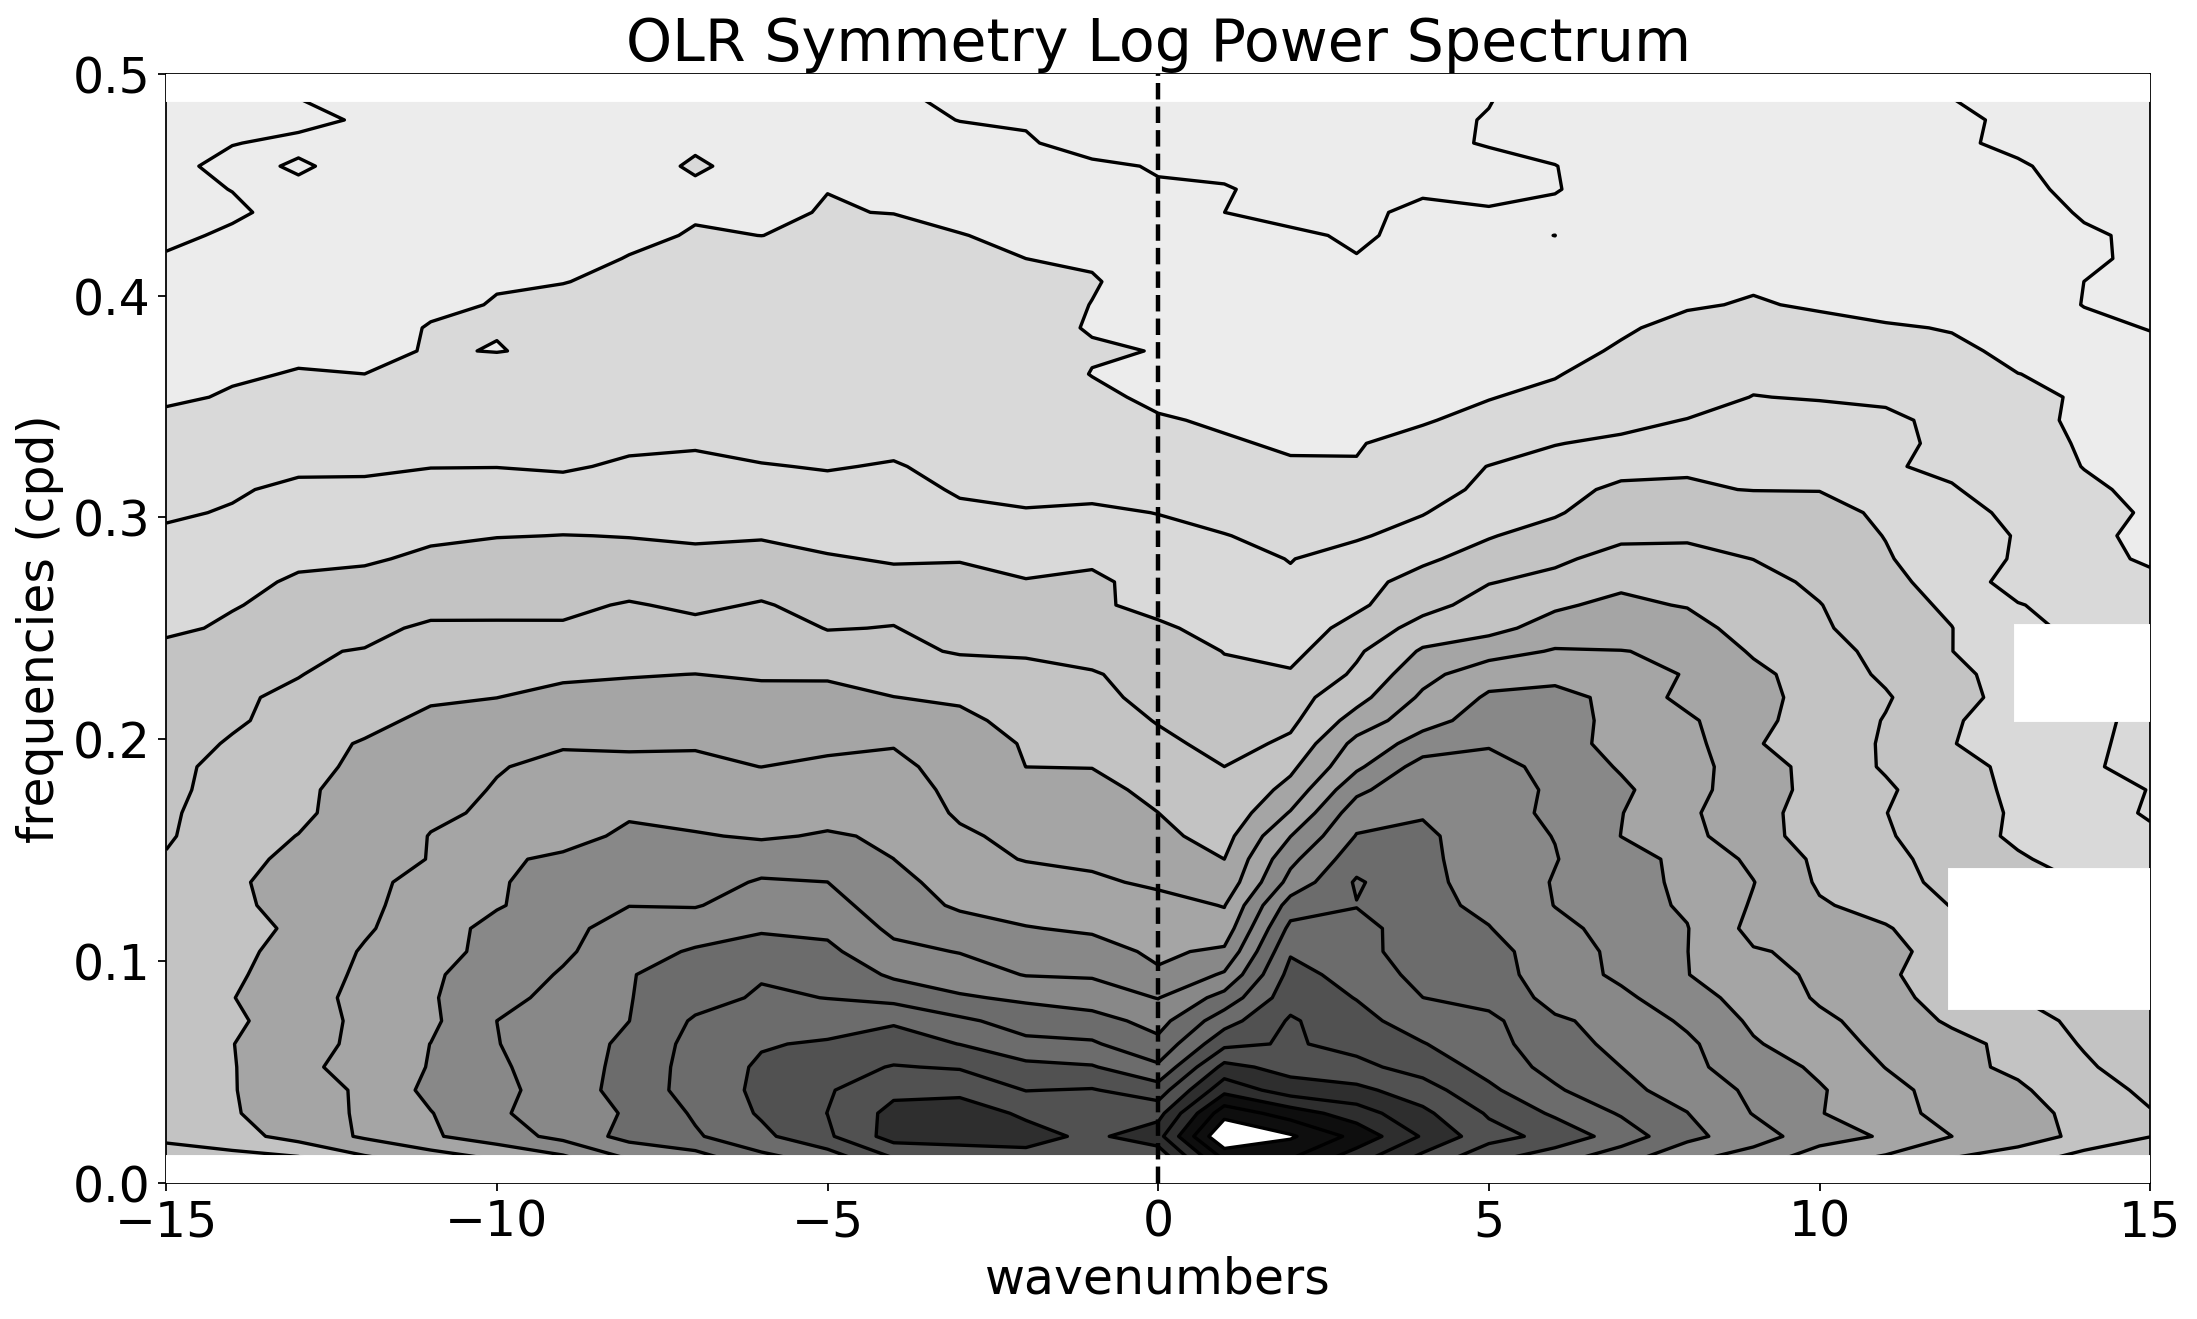

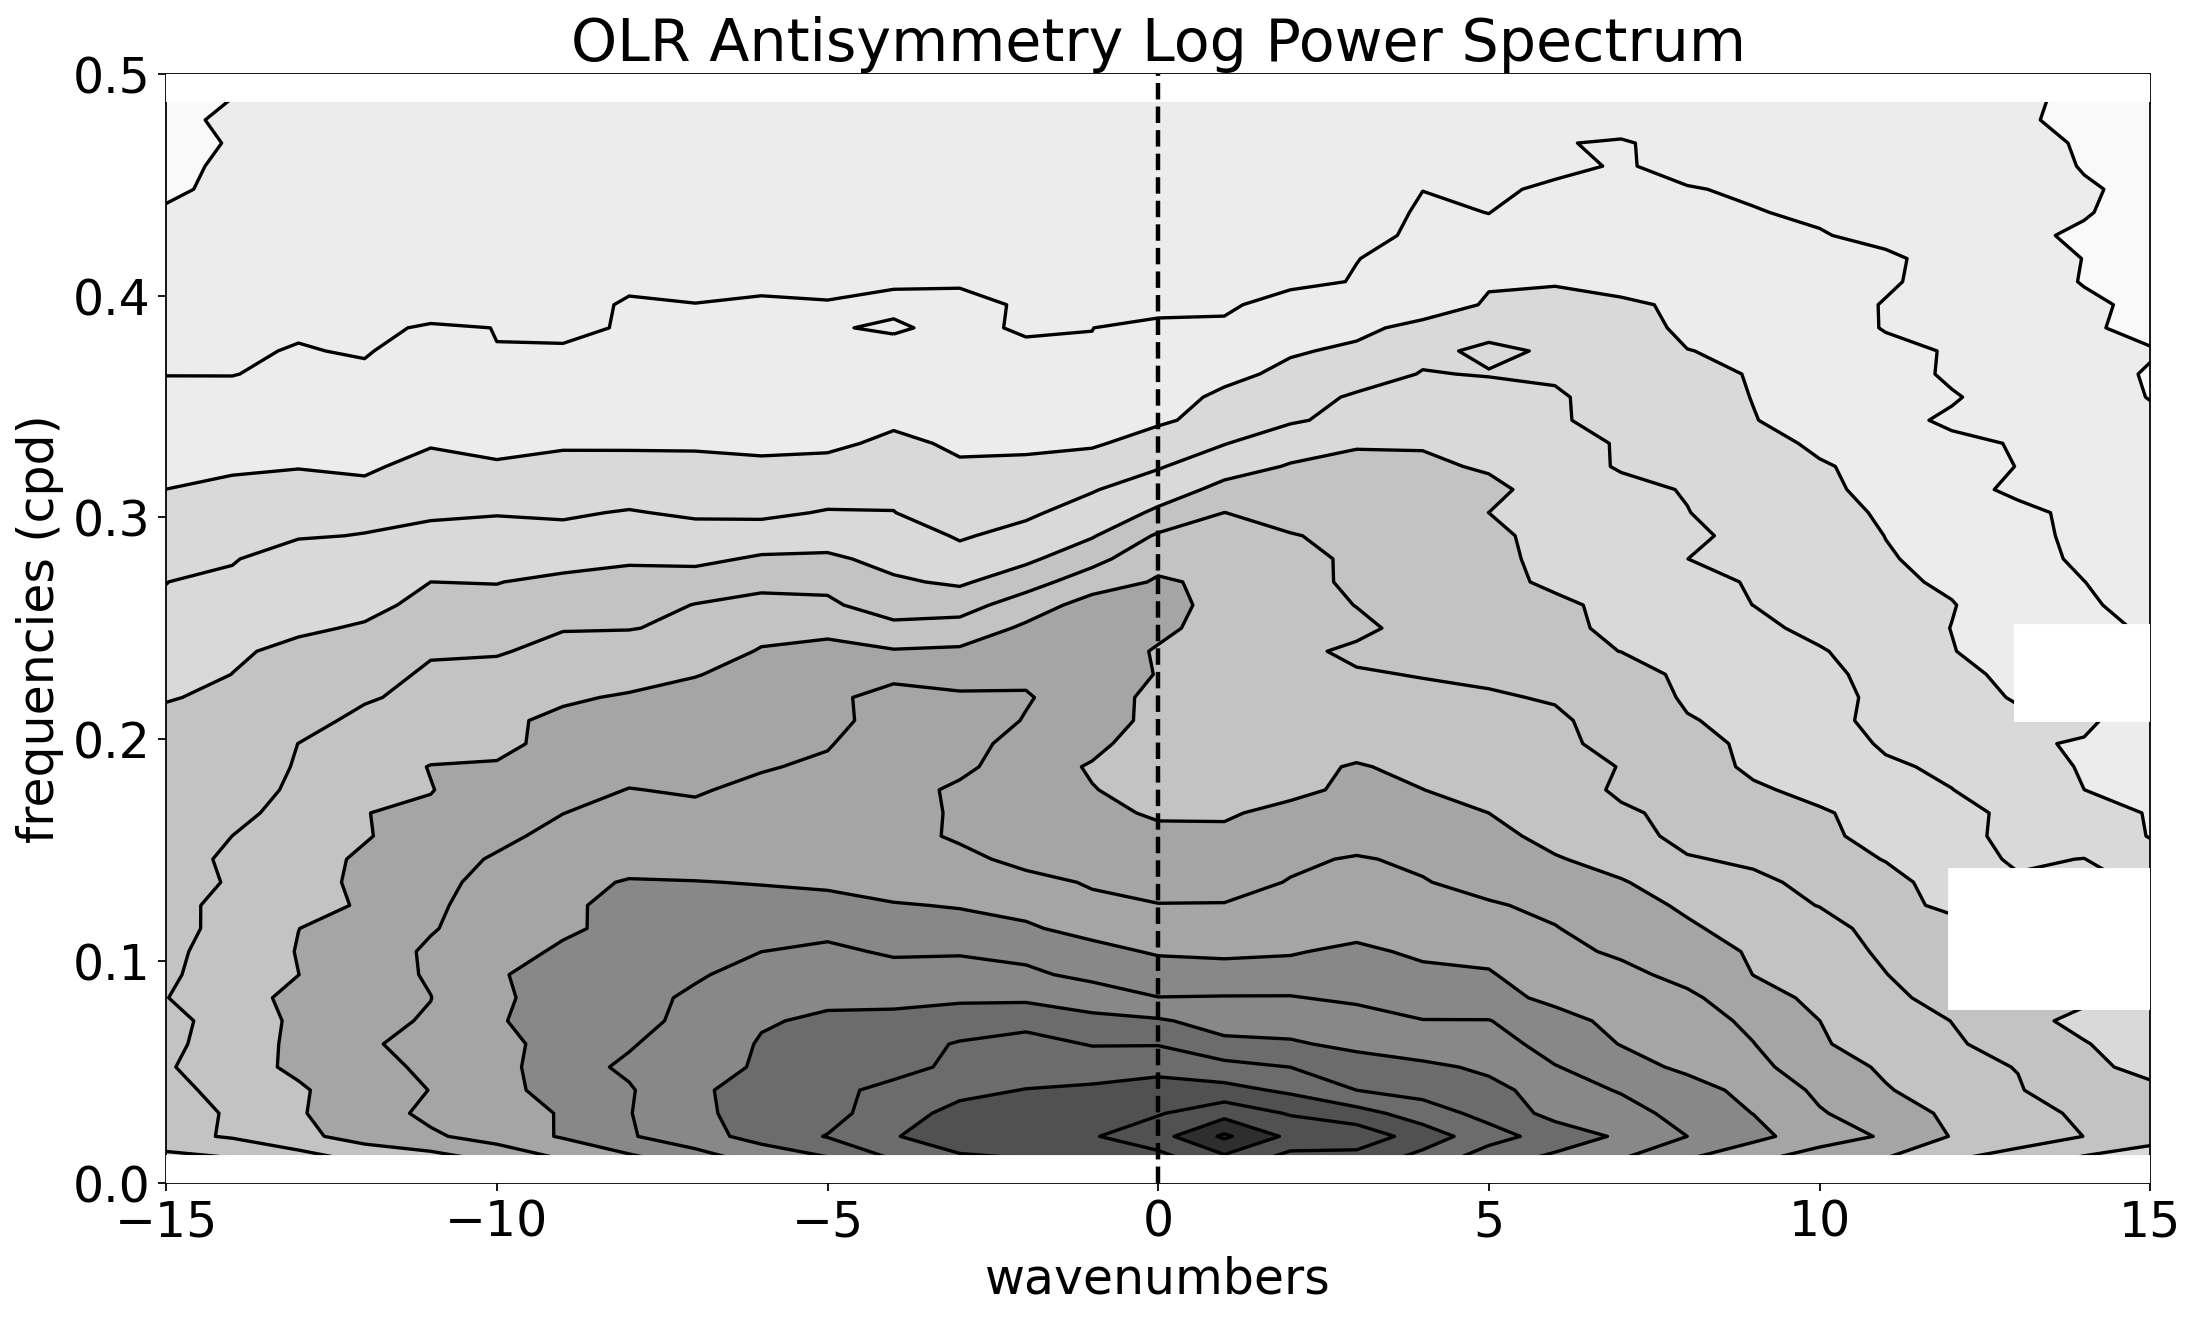

In [20]:
OLR_PSD_plot(psd_symmetric, spectral_grid, type="Symmetry")
OLR_PSD_plot(psd_antisymmetric, spectral_grid, type="Antisymmetry")

0

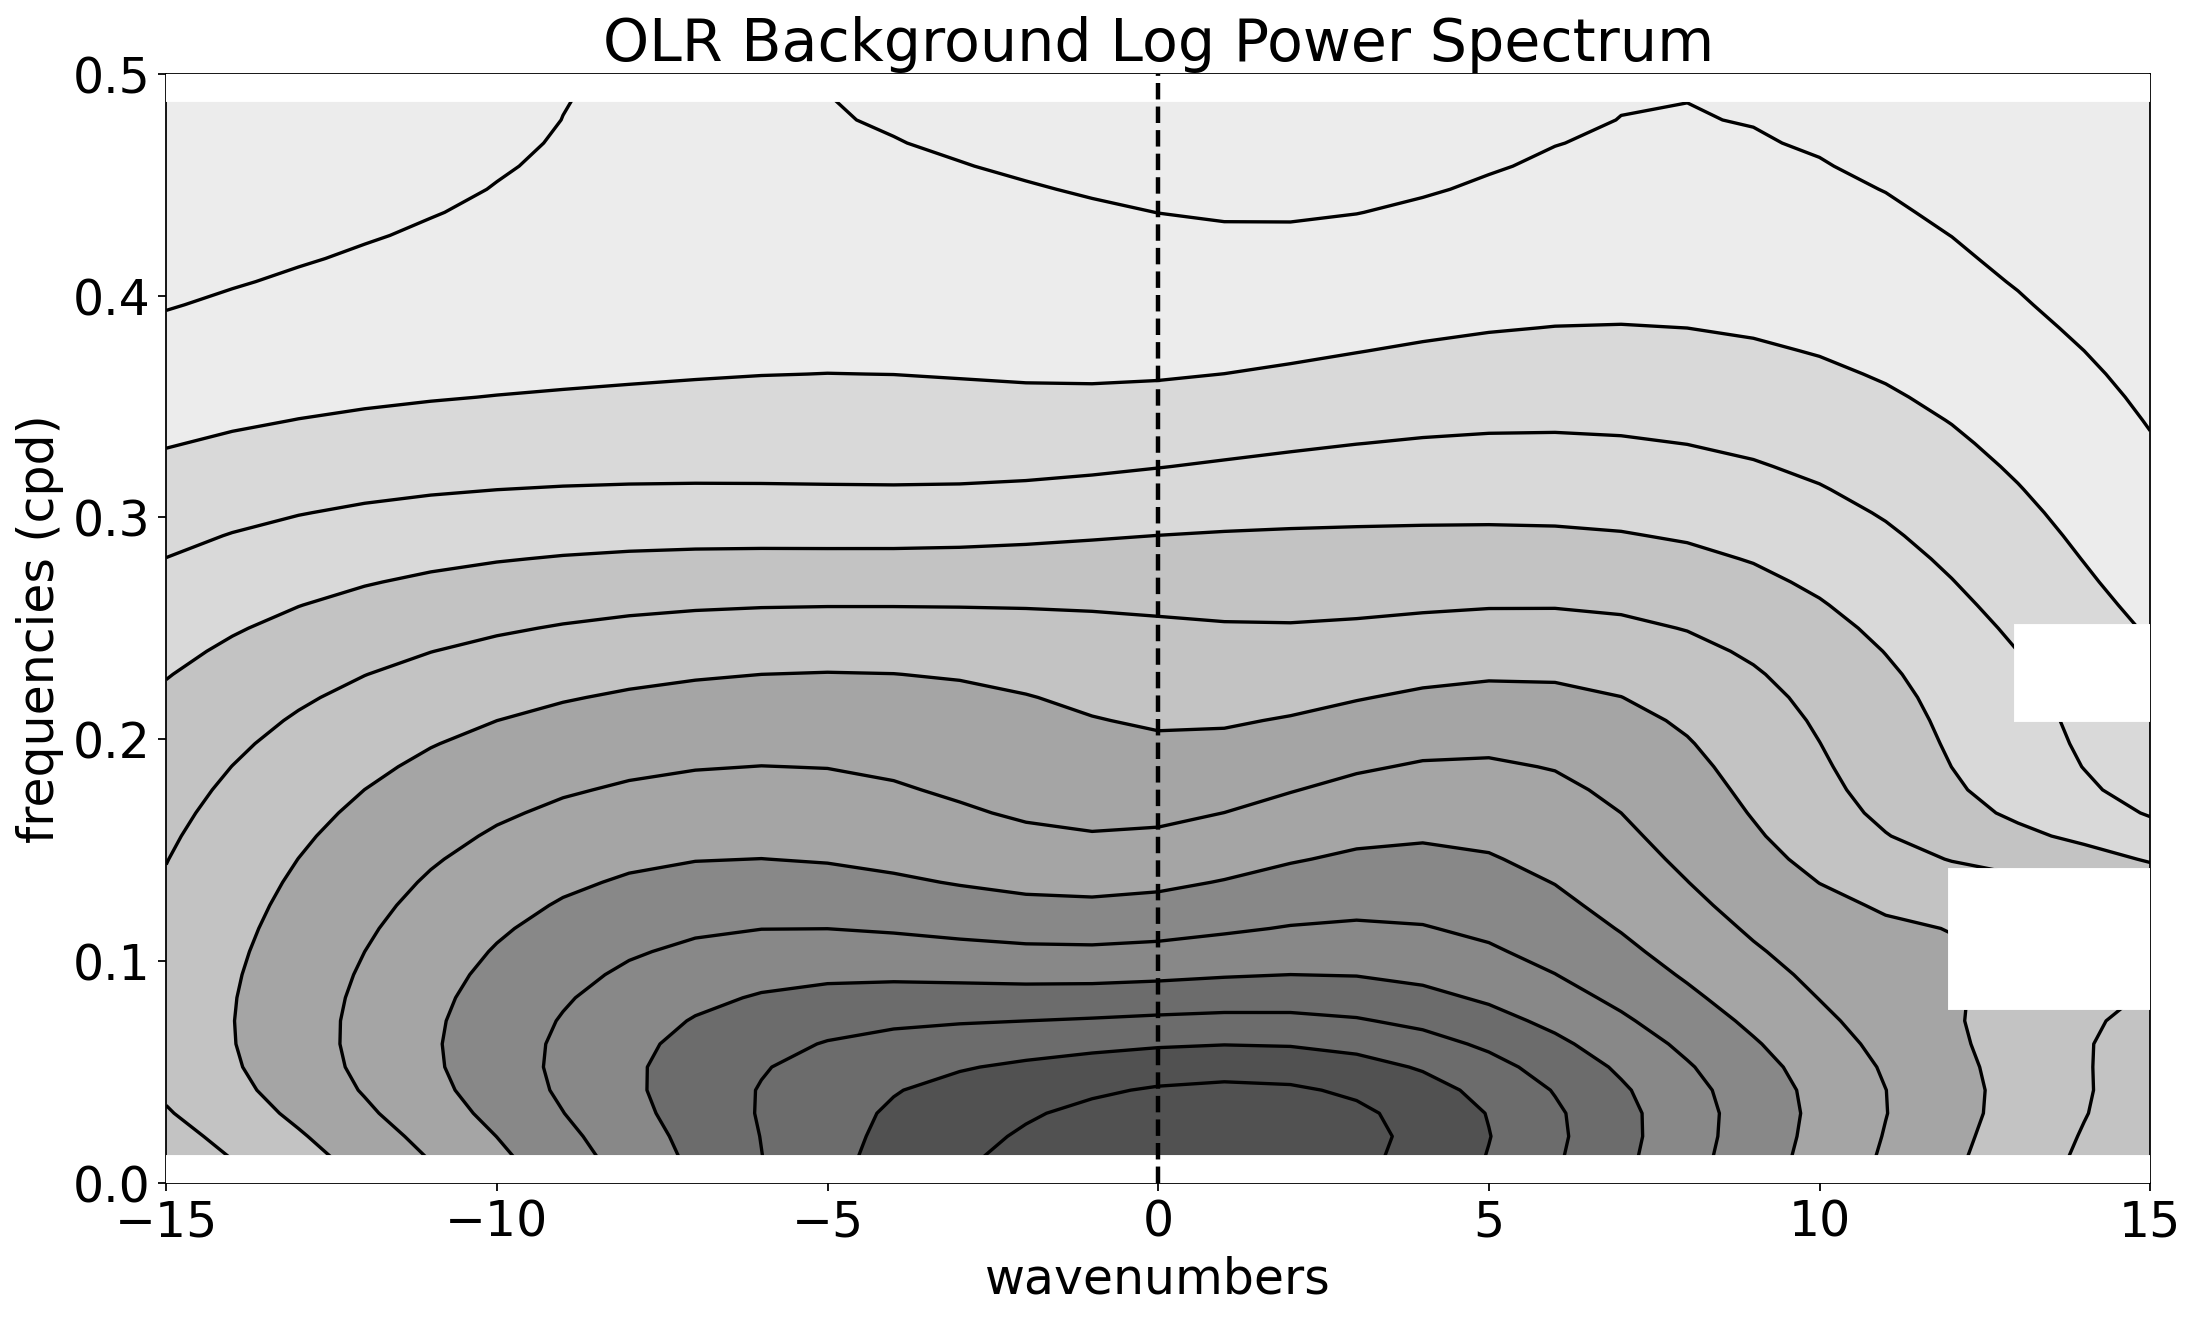

In [21]:
OLR_background_PSD_plot(background_psd, spectral_grid)

0

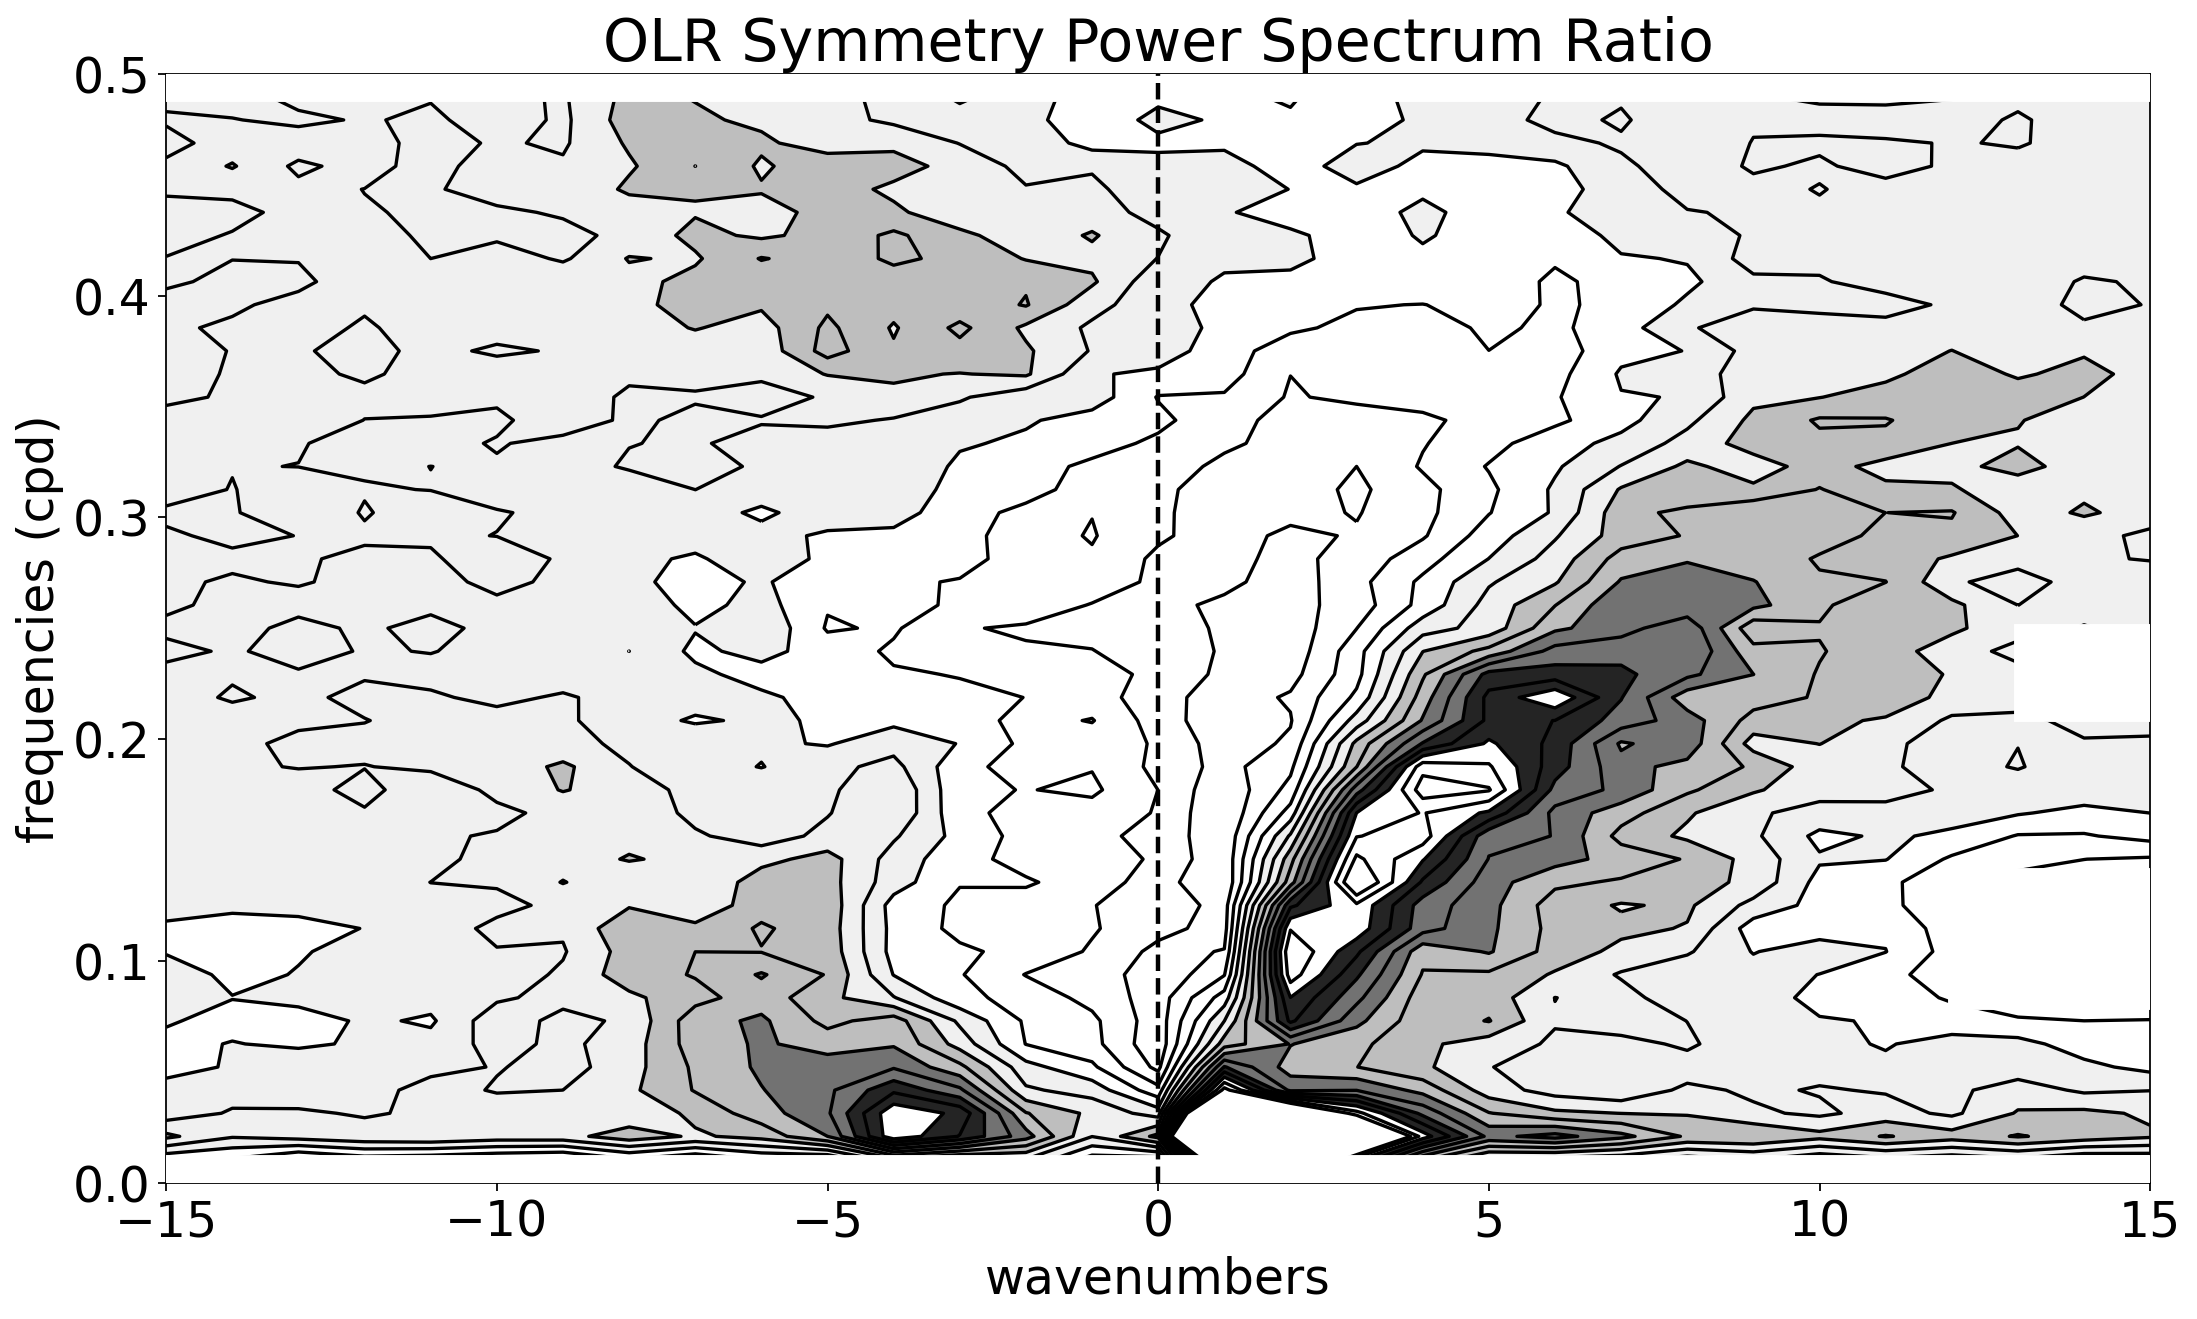

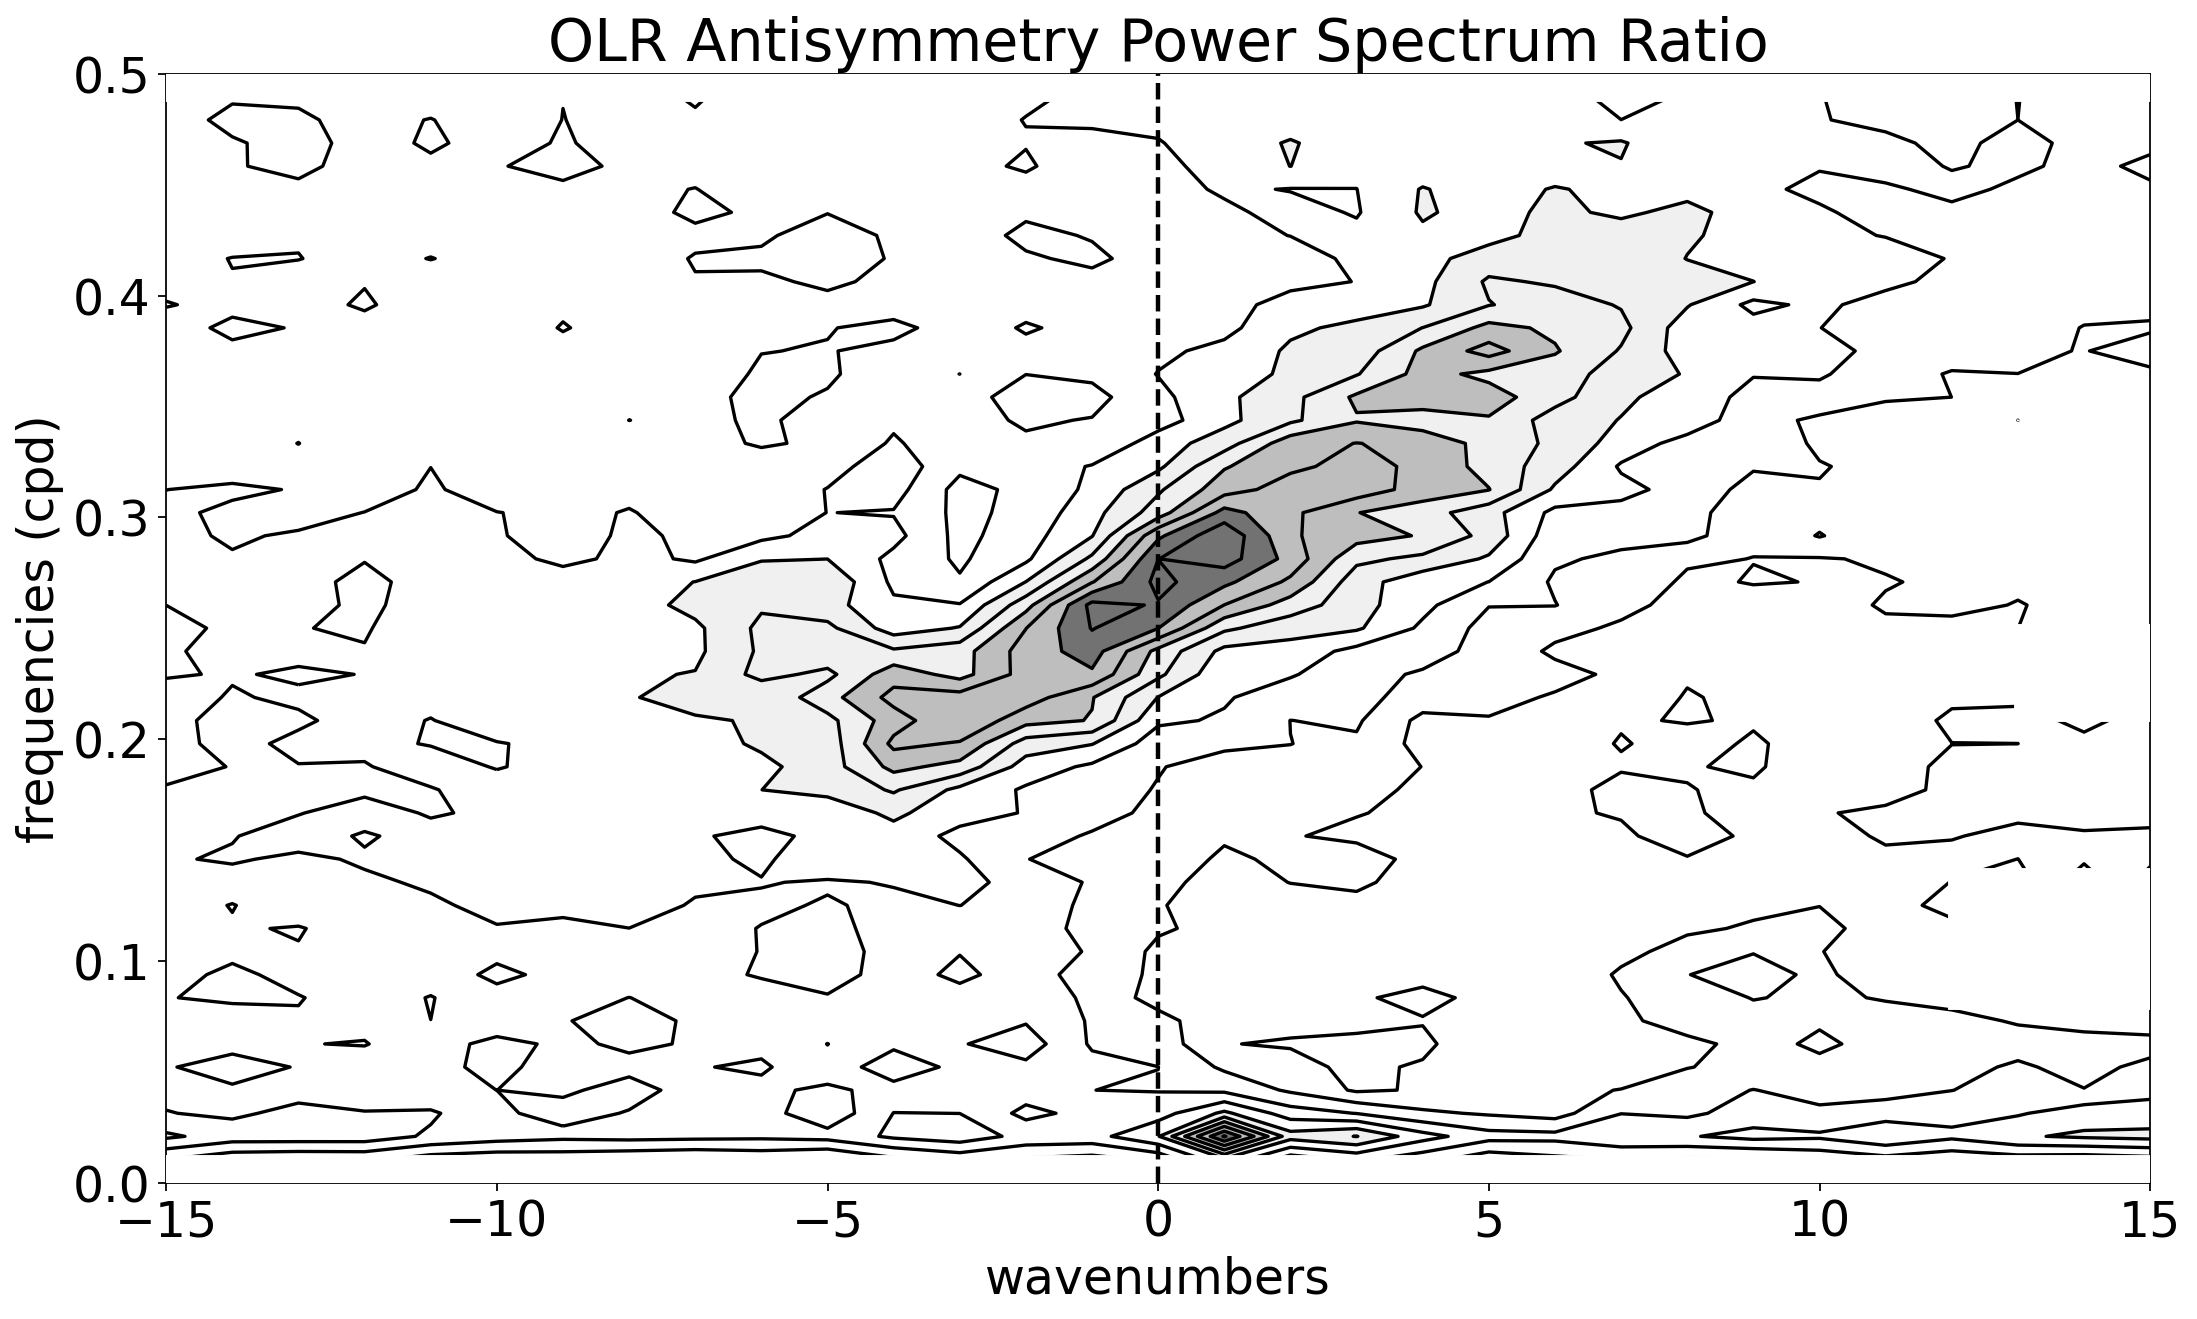

In [22]:
OLR_PSD_ratio_plot(psd_symmetric, background_psd, spectral_grid, type="Symmetry")
OLR_PSD_ratio_plot(
    psd_antisymmetric, background_psd, spectral_grid, type="Antisymmetry"
)